# Load Data

In [5]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
# Loading data from csv
df = pd.read_csv('Sarcasm_Model_Dataset.csv')
df.head()

# Splitting data into test and train (80:20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
# print(len(train_df))

168


# Frame Classifier

In [66]:
# load the model
model = ResNet50(weights='imagenet', include_top=False)


def feature_extract(data):
    numerical_values_list = []

    for i in range(len(data)):
        # print(i)
        # print(np.array(data['frame_1'][i].split()).astype(int))

        frame1 = np.array(data['frame_1'][i].split()).astype(int)
        frame2 = np.array(data['frame_2'][i].split()).astype(int)
        frame3 = np.array(data['frame_3'][i].split()).astype(int)

       # Stack the frames along the last axis to create a single array
        stacked_frames = np.concatenate([frame1, frame2, frame3], axis=-1)

        # Reshape the stacked frames to match the input shape expected by ResNet50
        stacked_frames = stacked_frames.reshape((1, 48, 48, 3)) 

        # Preprocess the input frames
        preprocessed_frames = preprocess_input(stacked_frames)

        # Extract features using the model
        frame_features = model.predict(preprocessed_frames)
        flattened_features = frame_features.reshape(frame_features.shape[0], -1)

        # Convert float values to integers if the decimal part is zero
        flattened_features_int = np.where(np.mod(flattened_features, 1) == 0, flattened_features.astype(int), flattened_features)
        
        # Convert the numpy array to a string
        features_string = np.array2string(flattened_features_int, separator=',')    
        # print(features_string)
        
        #convert to numerical values
        numerical_values = eval(features_string)

        numerical_values_list.append(numerical_values[0])

    data['visual_extract'] = numerical_values_list
    return data

# train_df = feature_extract(train_df)
# print(train_df.head())
# print(train_df)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df = feature_extract(train_df)
test_df = feature_extract(test_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [68]:
# Define a function to replace 'Ellipsis' with NaN in a list
def replace_ellipsis_with_nan(lst):
    return [np.nan if x == Ellipsis else x for x in lst]

# Apply the function to the visual_extract column for Data cleaning for both test and train data
test_df['visual_extract'] = test_df['visual_extract'].apply(replace_ellipsis_with_nan)
train_df['visual_extract'] = train_df['visual_extract'].apply(replace_ellipsis_with_nan)



In [99]:
# Reshape X in preparation for splitting
X= train_df['visual_extract'] 
X = np.array(X.explode()).reshape(len(X), -1)

y=train_df['sarcasm'] 

#Split data for test and train
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True) 

#Initiate the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
score = accuracy_score(y_pred, y_test)
# print(score)

visual_predictions =[]

def sarcasm_visualPercentage(data):
    test_pred = []

    for i in range(len(data)):
        outer = []
        prediction = []
        x_val = data['visual_extract'][i]
        outer.append(x_val)
        final_y = model.predict_proba(outer)
        result = final_y[0].reshape(1,-1).flatten().tolist()
        prediction.append(result[1])
        test_pred.append(prediction)

    print(test_pred)
    return test_pred

visual_predictions = sarcasm_visualPercentage(test_df)
flat_data = [item for sublist in visual_predictions for item in sublist]
visual_predictions = flat_data
print(visual_predictions)




[[0.48], [0.64], [0.46], [0.61], [0.4], [0.57], [0.68], [0.625909090909091], [0.829353193375252], [0.82723198125404], [0.56], [0.36], [0.24], [0.664847116119175], [0.3], [0.53], [0.14], [0.89], [0.4261076203208557], [0.44126369719555186], [0.51], [0.69], [0.44], [0.49], [0.42], [0.51], [0.69], [0.57], [0.41], [0.3], [0.4], [0.5], [0.33], [0.48], [0.59], [0.44126369719555186], [0.48], [0.89], [0.74], [0.5], [0.43], [0.47]]
[0.48, 0.64, 0.46, 0.61, 0.4, 0.57, 0.68, 0.625909090909091, 0.829353193375252, 0.82723198125404, 0.56, 0.36, 0.24, 0.664847116119175, 0.3, 0.53, 0.14, 0.89, 0.4261076203208557, 0.44126369719555186, 0.51, 0.69, 0.44, 0.49, 0.42, 0.51, 0.69, 0.57, 0.41, 0.3, 0.4, 0.5, 0.33, 0.48, 0.59, 0.44126369719555186, 0.48, 0.89, 0.74, 0.5, 0.43, 0.47]


**NEW** Visual Classifier
--

In [ ]:
import os
import numpy as np
from PIL import Image

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

#Creat
output_dir = 'train_images'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

columns_to_iterate = ['frame_1', 'frame_2', 'frame_3']

# Iterate through each column
for column in columns_to_iterate:
    # Create a directory for the current column if it doesn't exist
    column_dir = os.path.join(output_dir, column)
    if not os.path.exists(column_dir):
        os.makedirs(column_dir)
        
    sarcastic = os.path.join(column_dir, 'sarcastic')    
    not_sarcastic = os.path.join(column_dir, 'not_sarcastic')
    if not os.path.exists(sarcastic):
        os.makedirs(sarcastic)
    if not os.path.exists(not_sarcastic):
        os.makedirs(not_sarcastic)
        
    for i in range(len(train_df)): 
        pixel_values = np.array(train_df[column][i].split(), dtype=np.uint8)
        
        # Reshape pixel values into image dimensions
        image_array = pixel_values.reshape((48,48,1))
        image_array = np.repeat(image_array, 3, axis=2)
        # Create a PIL Image object
        image = Image.fromarray(image_array)
        
        if train_df['sarcasm'][i] == True:
            save_dir = sarcastic
        else:
            save_dir = not_sarcastic
        image.save(os.path.join(save_dir, f'image_{i}.png'))  # Assuming you want to save images as PNG files

In [ ]:
#Test images
output_dir = 'test_images'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

columns_to_iterate = ['frame_1', 'frame_2', 'frame_3']

# Iterate through each column
for column in columns_to_iterate:
    # Create a directory for the current column if it doesn't exist
    column_dir = os.path.join(output_dir, column)
    if not os.path.exists(column_dir):
        os.makedirs(column_dir)
    
    sarcastic = os.path.join(column_dir, 'sarcastic')    
    not_sarcastic = os.path.join(column_dir, 'not_sarcastic')
    if not os.path.exists(sarcastic):
        os.makedirs(sarcastic)
    if not os.path.exists(not_sarcastic):
        os.makedirs(not_sarcastic)

    for i in range(len(test_df)): 
        pixel_values = np.array(test_df[column][i].split(), dtype=np.uint8)
        
        # Reshape pixel values into image dimensions
        image_array = pixel_values.reshape((48,48,1))
        image_array = np.repeat(image_array, 3, axis=2)
        
        # Create a PIL Image object
        image = Image.fromarray(image_array)

        if train_df['sarcasm'][i] == True:
            save_dir = sarcastic
        else:
            save_dir = not_sarcastic
            
        image.save(os.path.join(save_dir, f'image_{i}.png'))  # Assuming you want to save images as PNG files

In [ ]:
#Creae generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_f1 = train_datagen.flow_from_directory(
    'train_images/frame_1/',
    target_size=(48,48),
    batch_size=32,
    class_mode='binary',
    classes=['sarcastic', 'not_sarcastic']
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_f1 = test_datagen.flow_from_directory(
    'test_images/frame_1/',
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    classes=['sarcastic', 'not_sarcastic'],
    shuffle=False
)

In [ ]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48, 3))

# Add custom classifier layers on top of ResNet50
x = base_model.output
#x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
output = Dense(1, activation='sigmoid')(x)

# Create the full model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (assumes you have train and validation generators)
history = resnet_model.fit(train_generator_f1, epochs=2)

In [ ]:
# Perform inference on test images
predictions = resnet_model.predict(test_generator_f1)

# Output the percentage that each image is sarcastic
print(predictions)

# Audio Classifier

In [10]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio
from skimage import color

In [85]:
#Sources: https://medium.com/@hasithsura/audio-classification-d37a82d6715
         #https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

#Define helper functions
max_audio_length = 10 #seconds

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<max_audio_length*sr:
    wav=np.pad(wav,int(np.ceil((max_audio_length*sr-wav.shape[0])/2)),mode='reflect') #pad audio by reflecting
  else:
    wav=wav[:max_audio_length*sr]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps) #z score normalization
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [86]:
#Convert .wav files to spectrogram images
audio_dir = 'audio_data'

def get_spec_images(filenames, directory):
    spec_images = []
    for filename in filenames:
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            spectrogram = get_melspectrogram_db(file_path)
            spec_image = spec_to_image(spectrogram)
            spec_images.append(spec_image)
    return spec_images

train_spec_images = get_spec_images(train_df['tone'], audio_dir)
train_spec_labels = train_df['sarcasm']

test_spec_images = get_spec_images(test_df['tone'], audio_dir)
test_spec_labels = test_df['sarcasm']

In [87]:
#divide the pixel values by 255
tone_train_norm = np.array(train_spec_images) 
tone_test_norm = np.array(test_spec_images)

#one-hot-encode the labels
tone_train_encoded = to_categorical(train_spec_labels)
tone_test_encoded = to_categorical(test_spec_labels)

In [89]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

#Build Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 862, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))  # Output layer with 1 unit for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [90]:
batch = 5
epochs = 15

#Fit the model
tone_model = model.fit(tone_train_norm, tone_train_encoded, batch_size=batch, epochs=epochs, validation_split = 0.2)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 899ms/step - accuracy: 0.4886 - loss: 57.1641 - val_accuracy: 0.5294 - val_loss: 111.0439
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 858ms/step - accuracy: 0.8178 - loss: 12.7584 - val_accuracy: 0.4706 - val_loss: 43.5550
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 870ms/step - accuracy: 0.8750 - loss: 3.4177 - val_accuracy: 0.5294 - val_loss: 137.5521
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.8889 - loss: 5.2951 - val_accuracy: 0.5588 - val_loss: 77.9172
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 908ms/step - accuracy: 0.9738 - loss: 0.5398 - val_accuracy: 0.5294 - val_loss: 46.8877
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 915ms/step - accuracy: 1.0000 - loss: 0.1293 - val_accuracy: 0.6176 - val_loss: 26.7946
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 662ms/step - accuracy: 1.0000 - loss: 0.1243 - val_accuracy: 0.5000 - val_loss: 33.4883
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 633ms/step - accuracy: 1.0000 - loss: 1.7198

[]

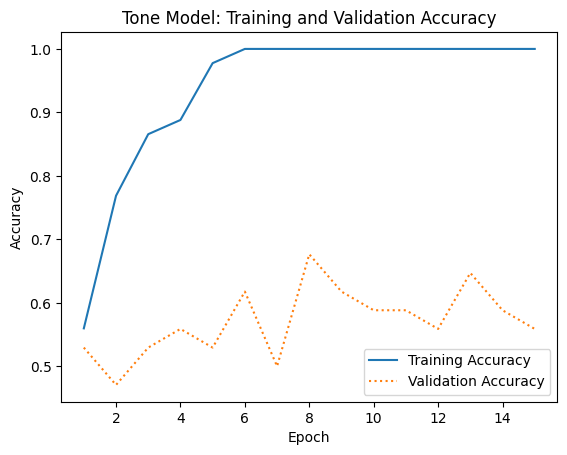

In [91]:
#Train and validation accuracy graph
accuracy = tone_model.history['accuracy']
validation_acc = tone_model.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, '-', label='Training Accuracy')
plt.plot(epochs, validation_acc, ':', label='Validation Accuracy')
plt.title('Tone Model: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [92]:
#make predictions on test set
tone_predictions = model.predict(tone_test_norm)

#Filter to only positive class
tone_predictions = tone_predictions[:, 1]
print(tone_predictions)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/stepWARNING:tensorflow:5 out of the last 214 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3018f5800> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
[6.56121901e-29 3.03542573e-11 9.92829800e-01 0.00000000e+00
 7.43079409e-02 1.00000000e+00 9.99955416e-01 1.00000000e+00
 9.88980078e-11 2.70515098e-03 1.00000000e+00 1.00000000e+00
 2.00071803e-19 4.4

# Text Classifer

In [78]:
# Load sentiment classifier
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

# Classify text and add sentiment and score columns to DataFrame
def classify_text(row):
    text = row['text']
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(**encoded_input)
    scores = output[0][0].numpy()  # Convert TensorFlow tensor to NumPy array
    scores = softmax(scores)
    ranking = np.argsort(scores)[::-1]
    l = config.id2label[ranking[0]]  # Take the label with highest score
    s = np.round(float(scores[ranking[0]]), 4)
    return pd.Series({'sentiment': l, 'score': s})

# Apply classifier to each row in the DataFrame
train_df[['sentiment', 'sentiment_score']] = train_df.apply(classify_text, axis=1)
test_df[['sentiment', 'sentiment_score']] = test_df.apply(classify_text, axis=1)

# Display the DataFrame with new columns
print(train_df.head())
print(test_df.head())

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


         video                                            frame_1  \
0    2_208.mp4  8 8 8 8 8 6 6 6 6 6 7 7 7 6 6 6 5 4 9 23 14 13...   
1    2_575.mp4  8 8 6 3 8 12 14 33 44 58 54 24 37 29 35 38 38 ...   
2    1_276.mp4  123 124 124 92 31 11 14 15 15 16 15 15 15 13 1...   
3  1_10890.mp4  53 58 63 44 59 155 169 168 167 164 163 161 161...   
4    2_514.mp4  72 97 132 169 162 136 81 155 191 175 194 195 2...   

                                             frame_2  \
0  2 2 2 2 2 2 3 3 3 3 3 2 3 2 1 17 20 14 15 15 1...   
1  2 1 5 15 20 19 13 30 49 33 23 32 33 29 24 29 2...   
2  93 30 3 4 5 6 5 5 6 6 6 7 7 7 9 5 4 4 6 4 2 5 ...   
3  59 57 33 59 70 39 40 46 148 166 161 163 164 16...   
4  181 195 222 197 178 210 230 248 230 105 13 15 ...   

                                             frame_3         tone  \
0  6 6 6 7 7 7 8 8 7 6 6 7 7 7 7 7 7 9 7 6 7 9 9 ...    2_208.wav   
1  14 13 3 1 10 21 19 14 38 42 34 27 45 42 30 26 ...    2_575.wav   
2  123 96 29 3 4 5 6 6 6 5 6 6 7 8 8 5 3 

In [79]:
# Encode labels
label_encoder = LabelEncoder()
train_df['sarcasm_encoded'] = label_encoder.fit_transform(train_df['sarcasm'])
test_df['sarcasm_encoded'] = label_encoder.fit_transform(test_df['sarcasm'])

# Text preprocessing
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_text_train = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_text_test = tfidf_vectorizer.transform(test_df['text']).toarray()

# Convert sentiment labels to numerical values
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['sentiment_encoded'] = train_df['sentiment'].map(sentiment_mapping)
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment_mapping)

# Combine text features with sentiment scores
X_train = np.concatenate((X_text_train, train_df[['sentiment_encoded', 'sentiment_score']].values), axis=1)
y_train = train_df['sarcasm_encoded']
X_test = np.concatenate((X_text_test, test_df[['sentiment_encoded', 'sentiment_score']].values), axis=1)
y_test = test_df['sarcasm_encoded']

In [81]:
# Training parameters
n_epochs = 24
n_batch = 24

# Define neural network architecture
text_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
text_model.fit(X_train, y_train, batch_size=n_batch, epochs=n_epochs, validation_split=0.2)

# Evaluate the model
loss, accuracy = text_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/24


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4961 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6237 - loss: 0.6843 - val_accuracy: 0.5588 - val_loss: 0.6923
Epoch 3/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7812 - loss: 0.6737 - val_accuracy: 0.4706 - val_loss: 0.6920
Epoch 4/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7780 - loss: 0.6600 - val_accuracy: 0.6176 - val_loss: 0.6893
Epoch 5/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8670 - loss: 0.6359 - val_accuracy: 0.5588 - val_loss: 0.6864
Epoch 6/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8168 - loss: 0.6216 - val_accuracy: 0.5588 - val_loss: 0.6833
Epoch 7/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8910 - loss: 0.5843 - val_accuracy: 0.5882 - val_loss: 0.6759
Epoch 8/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9289 - loss: 0.5403 - val_accuracy: 0.6471 - val_loss: 0.6656
Epoch 9/24
6/6 ━━━

In [82]:
# Predict values for the test set
text_predictions = text_model.predict(X_test)

# Predicted values are the percentage chance that the sample is sarcastic
print("Predicted Values:")
print(text_predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Values:
[[0.01338307]
 [0.47403687]
 [0.00595073]
 [0.45493087]
 [0.04313813]
 [0.14880016]
 [0.979605  ]
 [0.98235023]
 [0.98163176]
 [0.68775636]
 [0.9488258 ]
 [0.9871775 ]
 [0.0385867 ]
 [0.8809331 ]
 [0.07758151]
 [0.88759303]
 [0.00463013]
 [0.3764621 ]
 [0.9773659 ]
 [0.98987776]
 [0.66391766]
 [0.934929  ]
 [0.00446415]
 [0.09286518]
 [0.61998403]
 [0.09909386]
 [0.09665194]
 [0.02327172]
 [0.76476246]
 [0.00605615]
 [0.00997836]
 [0.9835106 ]
 [0.98152834]
 [0.8402107 ]
 [0.29439676]
 [0.03514736]
 [0.27921644]
 [0.9094459 ]
 [0.989778  ]
 [0.01768709]
 [0.10172091]
 [0.15565947]]


# Sarcasm Detection Model Using Late Fusion

In [103]:
# Weights
w_visual = 0
w_tone = 0.50
w_text = 0.50

# Value threshold - 50%
threshold = 0.5

num_rows = len(tone_predictions)

# Initialize lists to store the combined scores and predicted values
combined_scores = []
predicted_values = []
real_values = []

# Calculate combined scores and predicted values
for i in range(num_rows):
    combined_score = (w_tone * tone_predictions[i]) + (w_text * text_predictions[i])
    combined_scores.append(combined_score)
    
    # Store the label value for that row, True if above the threshold
    predicted_value = combined_score > threshold
    predicted_values.append(predicted_value)
    


# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'combined_score': combined_scores,
    'predicted_value': [item for sublist in predicted_values for item in sublist],
    'real_value': test_df['sarcasm']
})

# print(results_df)

# Create and display confusion matrix
cm = confusion_matrix(results_df['real_value'].astype(int), results_df['predicted_value'].astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
disp.plot()
plt.show()

# Create and display statistics
report = classification_report(results_df['real_value'].astype(int), results_df['predicted_value'].astype(int), target_names=['Not Sarcastic', 'Sarcastic'])

print("Statistics:")
print(report)

0.64
0.46
0.61
0.4
0.57
0.68
0.625909090909091
0.829353193375252
0.82723198125404
0.56
0.36
0.24
0.664847116119175
0.3
0.53
0.14
0.89
0.4261076203208557
0.44126369719555186
0.51
0.69
0.44
0.49
0.42
0.51
0.69
0.57
0.41
0.3
0.4
0.5
0.33
0.48
0.59
0.44126369719555186
0.48
0.89
0.74
0.5
0.43
0.47


IndexError: list index out of range